In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [184]:
#データの読み込み
category = pd.read_csv("./item_categories.csv")
items = pd.read_csv("./items.csv")
train = pd.read_csv("./sales_train.csv")
shops = pd.read_csv("./shops.csv")
test = pd.read_csv("./test.csv")

In [189]:
#trainのデータ型を確認
train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [191]:
#trainのdateをdatetimeに変換
train["date"] = pd.to_datetime(train.date, format="%d.%m.%Y")
train.dtypes

date              datetime64[ns]
date_block_num             int64
shop_id                    int64
item_id                    int64
item_price               float64
item_cnt_day             float64
dtype: object

In [192]:
#date列を日付順に並び変え
train = train.sort_values("date")

In [193]:
#各行の売り上げ[date_sales]列を追加
train["date_sales"] = train["item_price"] * train["item_cnt_day"]

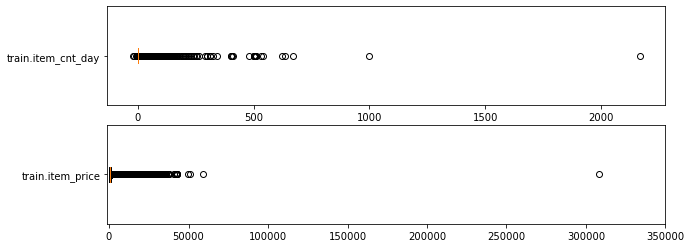

In [194]:
fig,ax = plt.subplots(2,1,figsize=(10,4))

# 製品の個数
# 尺度の調整
plt.xlim(-300, 3000)
# 箱ひげ図を描画
ax[0].boxplot((train.item_cnt_day) , labels=['train.item_cnt_day'], vert=False)

# 製品の価格
# 尺度の調整
plt.xlim(-1000, 350000)
# 箱ひげ図を描画
ax[1].boxplot((train.item_price) , labels=['train.item_price'], vert=False)
plt.show()

In [195]:
# 外れ値の除去
train = train[train['item_price'] > 0]
train = train[train['item_price'] < 50000]
train = train[train['item_cnt_day'] <1000]

# 返品分（item_cnt_day<0）は除去
train = train[train['item_cnt_day'] > 0]

In [196]:
#似たようなやつを確認
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

#trainのデータを統一
train.loc[train['shop_id'] == 0 ,'shop_id'] =57
train.loc[train['shop_id'] == 1 ,'shop_id'] =58
train.loc[train['shop_id'] == 10 ,'shop_id'] =11
train.loc[train['shop_id'] == 39 ,'shop_id'] =40
#testデータも同様
test.loc[test['shop_id'] == 0 ,'shop_id'] =57
test.loc[test['shop_id'] == 1 ,'shop_id'] =58
test.loc[test['shop_id'] == 10 ,'shop_id'] =11
test.loc[test['shop_id'] == 39 ,'shop_id'] =40

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [197]:
#shop名の文頭が地域名だったので、それらを抽出して[city]列として追加
shops["city"] = shops["shop_name"].apply(lambda x : x.split()[0])

In [198]:
#[city]列の中身をユニークで確認
shops["city"].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [199]:
#[city]列の!ЯкутскとЯкутскがほぼ同じなので統一
shops.loc[shops['city'] == '!Якутск', 'city'] ='Якутск'

In [200]:
#[city]列をラベルエンコード
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
shops["city"] = le.fit_transform(shops["city"])
#使わないので[shop_name]列を落とす
shops = shops.drop("shop_name", axis=1)
shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [201]:
#[shop]と同様に[item_category_name]の文頭を抽出し、[ctg]として追加
category["ctg"] = category["item_category_name"].apply(lambda x : x.split("-")[0])

In [204]:
#出現回数が1回しかないものが多くある
category.value_counts("ctg")

ctg
Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Игры PC                               4
Карты оплаты                          4
PC                                    1
Чистые носители (штучные)             1
Чистые носители (шпиль)               1
Служебные                             1
Служебные                             1
Карты оплаты (Кино, Музыка, Игры)     1
Игры MAC                              1
Игры Android                          1
Доставка товара                       1
Билеты (Цифра)                        1
Элементы питания                      1
dtype: int64

In [211]:
#[ctg]列の出現回数が4回以下のものを"etc"に変換
def make_etc(x):
    if len(category[category["ctg"] == x]) >= 4:
        return x
    else:
        return "etc"
    
category["ctg"] = category["ctg"].apply(lambda x : make_etc(x))

In [212]:
#[ctg]列をラベルエンコード
le = LabelEncoder()
category["ctg"] = le.fit_transform(category["ctg"])

In [218]:
category.head()

,item_category_name,item_category_id,ctg
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1


In [220]:
#全て結合したものをallとする
all = train.merge(shops, on="shop_id", how="inner")
all = train.merge(items, on="item_id", how="inner")
all = all.merge(category, on="item_category_id", how="inner")

In [228]:
#不要な列を削除
all = all.drop(["item_name", "item_category_name"], axis=1)
all.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sales,item_category_id,ctg
0,2013-01-01,0,18,5823,2500.0,1.0,2500.0,35,5
1,2013-01-01,0,54,5823,2499.5,1.0,2499.5,35,5
2,2013-01-02,0,54,5823,2500.0,1.0,2500.0,35,5
3,2013-01-02,0,42,5823,2490.0,1.0,2490.0,35,5
4,2013-01-02,0,56,5823,2500.0,1.0,2500.0,35,5


In [ ]:
item_cnt_month = []
def make_cnt_month(x):
    for i in str(x):
        item_cnt_month = all[all["date_block_num"]==i]["item_cnt_day"].sum()
    return item_cnt_month
        
all["item_cnt_month"] = all["date_block_num"].apply(lambda x : make_cnt_month(x))
all.head()

In [255]:
#各月ごとの商品販売個数[item_cnt_month]を追加
cnt_m = all.groupby("date_block_num", as_index=False).sum().iloc[:,[0,4]].rename(columns={'item_cnt_day': 'item_cnt_month'})
all = all.merge(cnt_m, on="date_block_num", how="inner")
all.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sales,item_category_id,ctg,item_cnt_month
0,2013-01-01,0,18,5823,2500.0,1.0,2500.0,35,5,131850.0
1,2013-01-01,0,54,5823,2499.5,1.0,2499.5,35,5,131850.0
2,2013-01-02,0,54,5823,2500.0,1.0,2500.0,35,5,131850.0
3,2013-01-02,0,42,5823,2490.0,1.0,2490.0,35,5,131850.0
4,2013-01-02,0,56,5823,2500.0,1.0,2500.0,35,5,131850.0


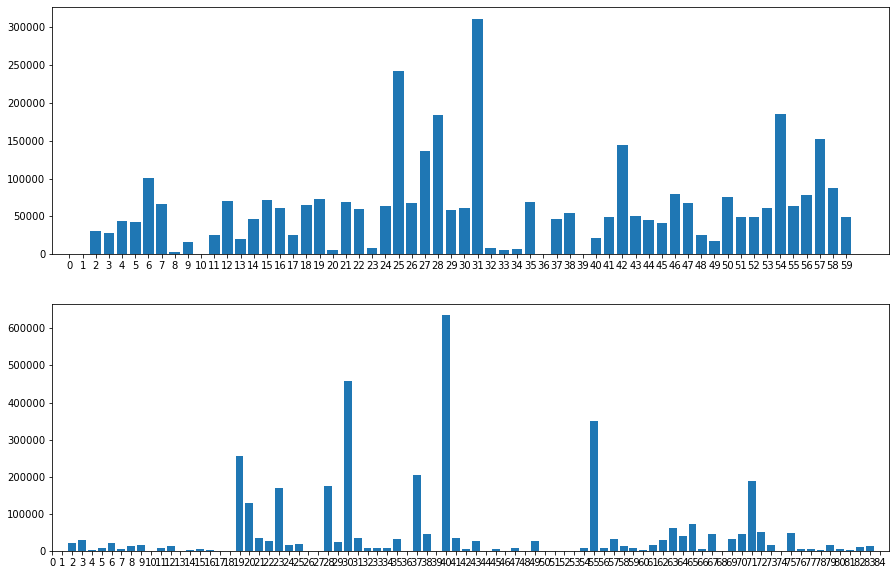

In [270]:
#shop、item_categoryごとの商品販売数のグラフを描画
shop_group = all.groupby("shop_id", as_index=False).sum().loc[:, ["shop_id","item_cnt_day"]]
category_group = all.groupby("item_category_id", as_index=False).sum().loc[:, ["item_category_id","item_cnt_day"]]

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.bar(shop_group.iloc[:,0], shop_group.iloc[:,1])
ax2.bar(category_group.iloc[:,0], category_group.iloc[:,1])

ax1.set_xticks(np.arange(0,60))
ax2.set_xticks(np.arange(0,85))
ax2.set_xlim(0,85)
plt.show()

In [ ]:
#ローリング特徴量の作成
window = all[""]

In [271]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [273]:
mon_shop_item_cnt = train[
    ['date_block_num','shop_id','item_id','item_cnt_day']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).sum().rename(columns={'item_cnt_day':'mon_shop_item_cnt'})

In [275]:
mon_shop_item_cnt

,date_block_num,shop_id,item_id,mon_shop_item_cnt
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1607366,33,59,22087,6.0
1607367,33,59,22088,2.0
1607368,33,59,22091,1.0
1607369,33,59,22100,1.0


In [276]:
# 月次shop_id*item_id別売上金額
mon_shop_item_sales = train[
    ['date_block_num','shop_id','item_id','date_sales']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).sum().rename(columns={'date_sales':'mon_shop_item_sales'})
mon_shop_item_sales

,date_block_num,shop_id,item_id,mon_shop_item_sales
0,0,2,27,2499.0
1,0,2,33,499.0
2,0,2,317,299.0
3,0,2,438,299.0
4,0,2,471,798.0
...,...,...,...,...
1607366,33,59,22087,714.0
1607367,33,59,22088,238.0
1607368,33,59,22091,179.0
1607369,33,59,22100,629.0


In [279]:
#testデータセットごとに[date_block_bum]を0~34で値を振る
#データ数はtestのデータサイズ214,200*35で[7,497,000 , 3]
train_full_comb = pd.DataFrame()
for i in range(35):
    mid = test[['shop_id','item_id']]
    mid['date_block_num'] = i
    train_full_comb = pd.concat([train_full_comb,mid],axis=0)

In [302]:
# 月次売上商品数
train_a = pd.merge(
    train_full_comb,
    mon_shop_item_cnt,
    on=['date_block_num','shop_id','item_id'],
    how='left'
)

# 月次売上金額
train_a = pd.merge(
    train_a,
    mon_shop_item_sales,
    on=['date_block_num','shop_id','item_id'],
    how='left'
)
# 学習データにマスタをマージ
# item_idのjoin
train_a = pd.merge(
    train_a,
    items[['item_id','item_category_id']],
    on='item_id',
    how='left'
)
# item_categry_idのjoin
train_a = pd.merge(
    train_a,
    category[['item_category_id','ctg']],
    on='item_category_id',
    how='left'
)
# shop_idのjoin
train_a = pd.merge(
    train_a,
    shops[['shop_id','city']],
    on='shop_id',
    how='left'
)


In [303]:
train_a

,shop_id,item_id,date_block_num,mon_shop_item_cnt,mon_shop_item_sales,item_category_id,ctg,city
0,5,5037,0,NaN,NaN,19,3,3
1,5,5320,0,NaN,NaN,55,8,3
2,5,5233,0,NaN,NaN,19,3,3
3,5,5232,0,NaN,NaN,23,3,3
4,5,5268,0,NaN,NaN,20,3,3
...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,55,8,20
7496996,45,16188,34,NaN,NaN,64,9,20
7496997,45,15757,34,NaN,NaN,55,8,20
7496998,45,19648,34,NaN,NaN,40,6,20


Text(0.5, 1.0, 'Montly item counts')

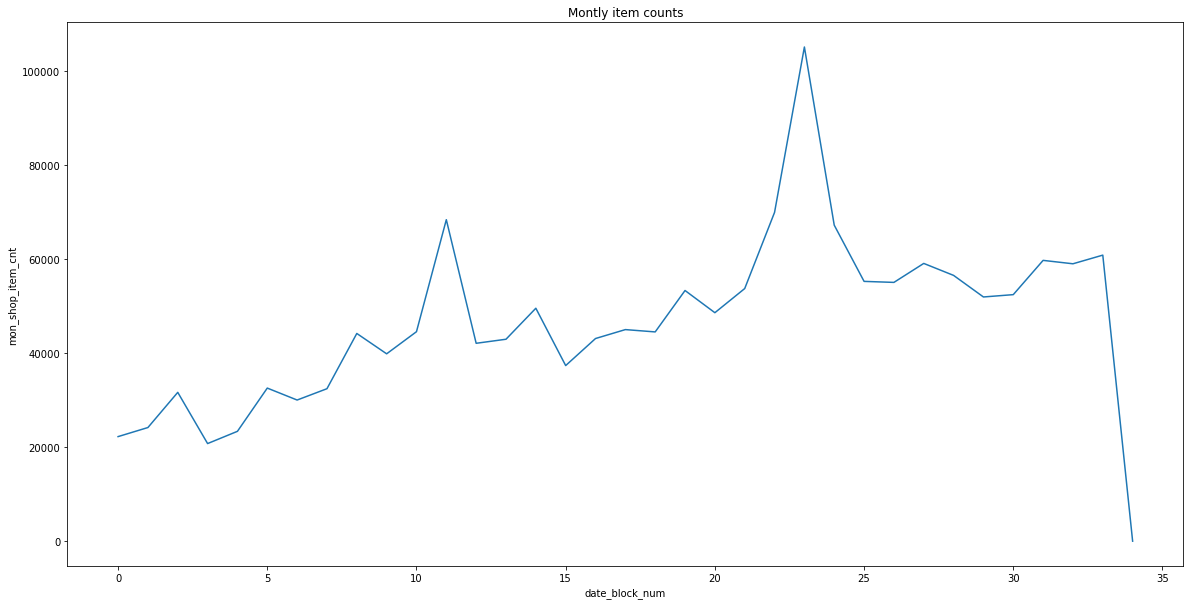

In [295]:
import seaborn as sns
plt_df = train_a.groupby(
    ['date_block_num'],
    as_index=False
).sum()
plt.figure(figsize=(20, 10))
sns.lineplot(x='date_block_num',y='mon_shop_item_cnt',data=plt_df)
plt.title('Montly item counts')

In [297]:
# 月次売上数をクリップ
train_a['mon_shop_item_cnt'] = train_a['mon_shop_item_cnt'].clip(0,20)

In [306]:
# ラグ生成対象のカラム
lag_col_list = ['mon_shop_item_cnt','mon_shop_item_sales']
# ラグリスト(1ヶ月前、3ヶ月前、6ヶ月前、9ヶ月前、12ヶ月前)
lag_num_list = [1,3,6,9,12]

# shop_id*item_id*date_block_numでソート
train_A = train_a.sort_values(
    ['shop_id', 'item_id','date_block_num'],
    ascending=[True, True,True]
).reset_index(drop=True)

# ラグ特徴量の生成
for lag_col in lag_col_list:
    for lag in lag_num_list:
        set_col_name =  lag_col + '_' +  str(lag)
        df_lag = train_a[['shop_id', 'item_id','date_block_num',lag_col]].sort_values(
            ['shop_id', 'item_id','date_block_num'],
            ascending=[True, True,True]
        ).reset_index(drop=True).shift(lag).rename(columns={lag_col: set_col_name})
        train_a = pd.concat([train_a, df_lag[set_col_name]], axis=1)

In [ ]:
train_a

In [93]:
df_train = []

# 同じ月のshop_id, item_idをグループ化
for i in train['date_block_num'].unique():
    all_shop  = train.loc[train['date_block_num'] == i, 'shop_id'].unique()
    all_item  = train.loc[train['date_block_num'] == i, 'item_id'].unique()
    df_train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id']
df_train = pd.DataFrame(np.vstack(df_train), columns=idx_features)

In [95]:
group = train.groupby(idx_features).agg({'item_cnt_day' : 'sum', 'item_price' : 'mean'}).reset_index()
group = group.rename(columns={'item_cnt_day' : 'item_cnt_month', 'item_price' : 'item_price_mean'})

df_train = df_train.merge(group, on=idx_features, how='left')

In [96]:
group = train.groupby(idx_features).agg({'item_cnt_day' : 'count'}).reset_index()
group = group.rename(columns={'item_cnt_day' : 'item_count'})

df_train = df_train.merge(group, on=idx_features, how='left')

In [97]:
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,18,5823,3.0,2500.0,3.0
1,0,18,5573,2.0,924.0,2.0
2,0,18,1006,NaN,NaN,NaN
3,0,18,17707,4.0,899.0,4.0
4,0,18,19548,NaN,NaN,NaN
